# Выбор локации для скважины

Рассматривается проблема добывающей компании. Нужно решить, где бурить новую скважину.

Предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Нужно остроить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализировать возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

In [1]:
# Импорт библиотеки pandas
import pandas as pd
# Импорт библиотеки numpy
import numpy as np
# Импорт библиотеки matplotlib
import matplotlib.pyplot as plt
# Импорт библиотеки math
import math
# Импорт библиотеки seaborn
import seaborn as sns
# Импорт библиотеки sklearn и необходимых компонентов
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler 
from sklearn.utils import shuffle
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error 
from scipy import stats as st
from scipy.stats import norm
# Удаление ложных предупреждений
pd.options.mode.chained_assignment = None  # default='warn'

<font color='DarkBlue'> 
📌 Импортированы все библиотеки, используемые далее в проекте, и скорректированы настройки <br>
</font> 

### Анализ датасета первого региона

In [2]:
# Загрузка таблицы в память переменной df типа dataframe
df_1 = pd.read_csv('/datasets/geo_data_0.csv')
# Разделители для удобства отображения информации указаны в виде отдельных пунктов 'print("\033[1m\033[43m {}".format('----- Text -----'),"\033[0m")'
print('\033[1m\033[43m {}'.format('----- Просмотр общей информации о dataframe -----'),'\033[0m')
df_1.info()
print('\033[1m\033[43m {}'.format('----- Информация о заголовках полей dataframe -----'),'\033[0m')
print(df_1.columns)
print('\033[1m\033[43m {}'.format('----- Информация о типах полей dataframe -----'),'\033[0m')
print(df_1.dtypes)
print('\033[1m\033[43m {}'.format('----- Отображение на экране в читаемом виде первых записей таблицы dataframe для визуального анализа -----'),'\033[0m')
display(df_1.head())
print('Количество явных дубликатов', df_1.duplicated().sum())

 ----- Просмотр общей информации о dataframe ----- 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
 ----- Информация о заголовках полей dataframe ----- 
Index(['id', 'f0', 'f1', 'f2', 'product'], dtype='object')
 ----- Информация о типах полей dataframe ----- 
id          object
f0         float64
f1         float64
f2         float64
product    float64
dtype: object
 ----- Отображение на экране в читаемом виде первых записей таблицы dataframe для визуального анализа ----- 


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


Количество явных дубликатов 0


<font color='DarkBlue'> 
📌 В ходе первичного анализа данных сформированы следующие выводы: <br>
    
1. Отсутствует необходимость в редактировании заголовков, названия представлены в условно общепринятом формате 'Змеиный регистр'
2. Отсутствуют пропуски и явные дубликаты, на данном этапе удаление строк не требуется. Можно рассмотреть количество записей с одинаковыми числовыми параметрами, например, с точностью до 3 знака
3. Тип данных некоторых числовых полей желательно преобразовать для уменьшения объема памяти хранения данных
4. В данных таблицы некорректные значения не наблюдаются. Необходимо детально рассмотреть параметры каждого столбца
</font> 

In [3]:
print('Количество возможных дубликатов', round(df_1.drop('id', axis=1),3).duplicated().sum())
df_1[round(df_1.drop('id', axis=1),3).duplicated(keep=False)].sort_values(by='f0')

Количество возможных дубликатов 0


,id,f0,f1,f2,product


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


,id
count,100000
unique,99990
top,74z30
freq,2


-----
74z30    2
bxg6G    2
TtcGQ    2
fiKDv    2
QcMuo    2
        ..
dFvJv    1
xaEGZ    1
cPGZe    1
LiW2W    1
yXCSX    1
Name: id, Length: 99990, dtype: int64
-----
f0


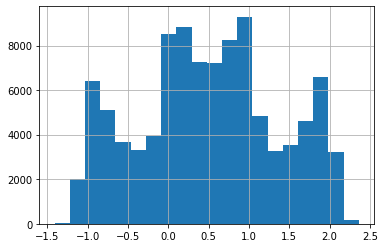

f1


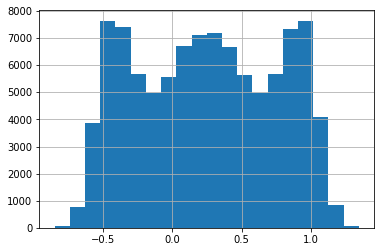

f2


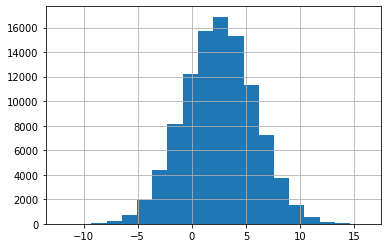

product


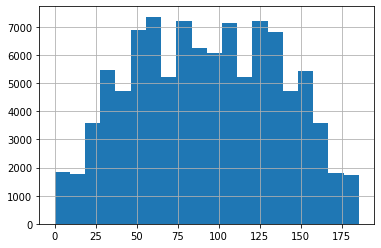

In [4]:
display(df_1.describe())
try:
    display(df_1.describe(include = ['object','bool','datetime']))
    for i in df_1.select_dtypes(include=['object','bool','datetime']):
        print('-----')
        if df_1[i].count() != len(df_1[i].unique()):
            print(df_1[i].value_counts())
        else:
            print('Все значения уникальны')
except:
    print('Все данные представлены в числовом формате')
print('-----')
for i in df_1:     
    if not ((df_1[i].dtype == 'object') & (len(df_1[i].unique()) > 20)):
        print(i)
        if (len(df_1[i].unique()) < 20):
            df_1[i].hist(bins=len(df_1[i].unique()))
            plt.show()  
        else:        
            df_1[i].hist(bins=20)
            plt.show()

In [5]:
df_1[df_1['id'] == 'HZww2']    

,id,f0,f1,f2,product
931,HZww2,0.755284,0.368511,1.863211,30.681774
7530,HZww2,1.061194,-0.373969,10.430210,158.828695


<font color='DarkBlue'> 
📌 Дубликаты, определяемые по подобным параметрам скважин, отсутствуют <br>
📌 В базе присутствует 10 скважин с одинаковыми идентификаторами, возможно неверно обозначенных по причине наличия ручной ошибки или менее вероятно повторно исследуемых вследствие технологической ошибки, так как остальные их параметры не совпадают, о чем свидетельствует отсутствие дубликатов и выборочное сравнение одного из объектов <br>  
📌 Объем запасов в скважинах нормально варьируется от 0 (абсолютно убыточные) до 186. Остальные параметры имеют также подобное распределение со снижением значений у периферий гистограммы <br>  
📌 Рекомендуется преобразовать типы данных полей для оптимизации памяти <br>  
📌 Необходимо удалить столбцы, не несущие полезной информации, так как модель машинного обучения использует все имеющиеся в своем алгоритме и пытается организовать возможные неполезные связи: 'id' <br>  
</font>

In [6]:
df_1[df_1.select_dtypes(include=['int']).columns] = df_1.select_dtypes(include=['int']).apply(pd.to_numeric,downcast='unsigned')
df_1[df_1.select_dtypes(include=['float']).columns] = df_1.select_dtypes(include=['float']).apply(pd.to_numeric,downcast='float')
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float32
 2   f1       100000 non-null  float32
 3   f2       100000 non-null  float32
 4   product  100000 non-null  float32
dtypes: float32(4), object(1)
memory usage: 2.3+ MB


In [7]:
df_1 = df_1.drop(['id'], axis=1)

### Анализ датасета второго региона

In [8]:
# Загрузка таблицы в память переменной df типа dataframe
df_2 = pd.read_csv('/datasets/geo_data_1.csv')
# Разделители для удобства отображения информации указаны в виде отдельных пунктов 'print("\033[1m\033[43m {}".format('----- Text -----'),"\033[0m")'
print("\033[1m\033[43m {}".format('----- Просмотр общей информации о dataframe -----'),"\033[0m")
df_2.info()
print("\033[1m\033[43m {}".format('----- Информация о заголовках полей dataframe -----'),"\033[0m")
print(df_2.columns)
print("\033[1m\033[43m {}".format('----- Информация о типах полей dataframe -----'),"\033[0m")
print(df_2.dtypes)
print("\033[1m\033[43m {}".format('----- Отображение на экране в читаемом виде первых записей таблицы dataframe для визуального анализа -----'),"\033[0m")
display(df_2.head())
print('Количество явных дубликатов', df_2.duplicated().sum())

 ----- Просмотр общей информации о dataframe ----- 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
 ----- Информация о заголовках полей dataframe ----- 
Index(['id', 'f0', 'f1', 'f2', 'product'], dtype='object')
 ----- Информация о типах полей dataframe ----- 
id          object
f0         float64
f1         float64
f2         float64
product    float64
dtype: object
 ----- Отображение на экране в читаемом виде первых записей таблицы dataframe для визуального анализа ----- 


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


Количество явных дубликатов 0


<font color='DarkBlue'> 
📌 В ходе первичного анализа данных сформированы следующие выводы: <br>
    
1. Отсутствует необходимость в редактировании заголовков, названия представлены в условно общепринятом формате 'Змеиный регистр'
2. Отсутствуют пропуски и явные дубликаты, на данном этапе удаление строк не требуется. Можно рассмотреть количество записей с одинаковыми числовыми параметрами, например, с точностью до 3 знака
3. Тип данных некоторых числовых полей желательно преобразовать для уменьшения объема памяти хранения данных
4. В данных таблицы некорректные значения не наблюдаются. Необходимо детально рассмотреть параметры каждого столбца
</font> 

In [9]:
print('Количество возможных дубликатов', round(df_2.drop('id', axis=1),3).duplicated().sum())
df_2[round(df_2.drop('id', axis=1),3).duplicated(keep=False)].sort_values(by='f0')

Количество возможных дубликатов 0


,id,f0,f1,f2,product


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


,id
count,100000
unique,99996
top,LHZR0
freq,2


-----
LHZR0    2
wt4Uk    2
5ltQ6    2
bfPNe    2
k9eWZ    1
        ..
odVIP    1
U6s3F    1
9234p    1
fQckt    1
3eFee    1
Name: id, Length: 99996, dtype: int64
-----
f0


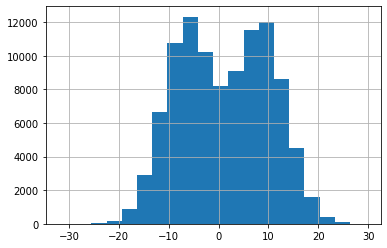

f1


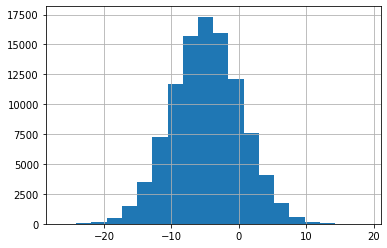

f2


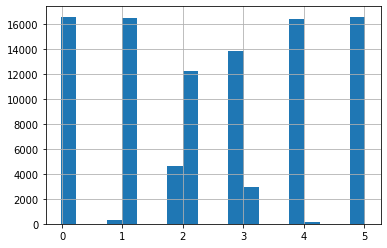

product


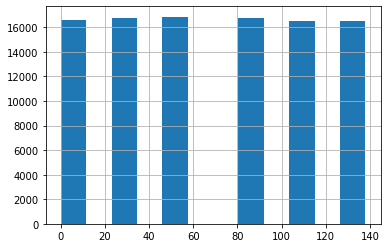

In [10]:
display(df_2.describe())
try:
    display(df_2.describe(include = ['object','bool','datetime']))
    for i in df_2.select_dtypes(include=['object','bool','datetime']):
        print('-----')
        if df_2[i].count() != len(df_2[i].unique()):
            print(df_2[i].value_counts())
        else:
            print('Все значения уникальны')
except:
    print('Все данные представлены в числовом формате')
print('-----')
for i in df_2:     
    if not ((df_2[i].dtype == 'object') & (len(df_2[i].unique()) > 20)):
        print(i)
        if (len(df_2[i].unique()) < 20):
            df_2[i].hist(bins=len(df_2[i].unique()))
            plt.show()  
        else:        
            df_2[i].hist(bins=20)
            plt.show()

In [11]:
df_2[df_2['id'] == 'LHZR0']

,id,f0,f1,f2,product
1305,LHZR0,11.170835,-1.945066,3.002872,80.859783
41906,LHZR0,-8.989672,-4.286607,2.009139,57.085625


<font color='DarkBlue'> 
📌 Дубликаты, определяемые по подобным параметрам скважин, отсутствуют <br>
📌 В базе присутствует 4 скважины с одинаковыми идентификаторами, возможно неверно обозначенных по причине наличия ручной ошибки или менее вероятно повторно исследуемых вследствие технологической ошибки, так как остальные их параметры не совпадают, о чем свидетельствует отсутствие дубликатов и выборочное сравнение одного из объектов <br>  
📌 Объем запасов в скважинах варьируется от 0 (абсолютно убыточные) до 138 явно выраженным сгруппированным методом, сконцентрированным около выделенных значений. Остальные параметры имеют также подобную группировку и нормальное распределение со снижением значений у периферий гистограммы <br>  
📌 Рекомендуется преобразовать типы данных полей для оптимизации памяти <br>  
📌 Необходимо удалить столбцы, не несущие полезной информации: 'id' <br>  
</font>

In [12]:
df_2[df_2.select_dtypes(include=['int']).columns] = df_2.select_dtypes(include=['int']).apply(pd.to_numeric,downcast='unsigned')
df_2[df_2.select_dtypes(include=['float']).columns] = df_2.select_dtypes(include=['float']).apply(pd.to_numeric,downcast='float')
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float32
 2   f1       100000 non-null  float32
 3   f2       100000 non-null  float32
 4   product  100000 non-null  float32
dtypes: float32(4), object(1)
memory usage: 2.3+ MB


In [13]:
df_2 = df_2.drop(['id'], axis=1)

### Анализ датасета третьего региона

In [14]:
# Загрузка таблицы в память переменной df типа dataframe
df_3 = pd.read_csv('/datasets/geo_data_2.csv')
# Разделители для удобства отображения информации указаны в виде отдельных пунктов 'print("\033[1m\033[43m {}".format('----- Text -----'),"\033[0m")'
print("\033[1m\033[43m {}".format('----- Просмотр общей информации о dataframe -----'),"\033[0m")
df_3.info()
print("\033[1m\033[43m {}".format('----- Информация о заголовках полей dataframe -----'),"\033[0m")
print(df_3.columns)
print("\033[1m\033[43m {}".format('----- Информация о типах полей dataframe -----'),"\033[0m")
print(df_3.dtypes)
print("\033[1m\033[43m {}".format('----- Отображение на экране в читаемом виде первых записей таблицы dataframe для визуального анализа -----'),"\033[0m")
display(df_3.head())
print('Количество явных дубликатов', df_3.duplicated().sum())

 ----- Просмотр общей информации о dataframe ----- 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
 ----- Информация о заголовках полей dataframe ----- 
Index(['id', 'f0', 'f1', 'f2', 'product'], dtype='object')
 ----- Информация о типах полей dataframe ----- 
id          object
f0         float64
f1         float64
f2         float64
product    float64
dtype: object
 ----- Отображение на экране в читаемом виде первых записей таблицы dataframe для визуального анализа ----- 


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


Количество явных дубликатов 0


<font color='DarkBlue'> 
📌 В ходе первичного анализа данных сформированы следующие выводы: <br>
    
1. Отсутствует необходимость в редактировании заголовков, названия представлены в условно общепринятом формате 'Змеиный регистр'
2. Отсутствуют пропуски и явные дубликаты, на данном этапе удаление строк не требуется. Можно рассмотреть количество записей с одинаковыми числовыми параметрами, например, с точностью до 3 знака
3. Тип данных некоторых числовых полей желательно преобразовать для уменьшения объема памяти хранения данных
4. В данных таблицы некорректные значения не наблюдаются. Необходимо детально рассмотреть параметры каждого столбца
</font> 

In [15]:
print('Количество возможных дубликатов', round(df_3.drop('id', axis=1),3).duplicated().sum())
df_3[round(df_3.drop('id', axis=1),3).duplicated(keep=False)].sort_values(by='f0')

Количество возможных дубликатов 0


,id,f0,f1,f2,product


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


,id
count,100000
unique,99996
top,Vcm5J
freq,2


-----
Vcm5J    2
VF7Jo    2
xCHr8    2
KUPhW    2
krjlo    1
        ..
wVB4S    1
pBwCV    1
L6oja    1
yf9Mw    1
XL56l    1
Name: id, Length: 99996, dtype: int64
-----
f0


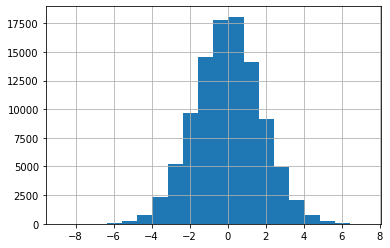

f1


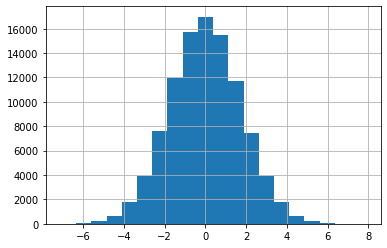

f2


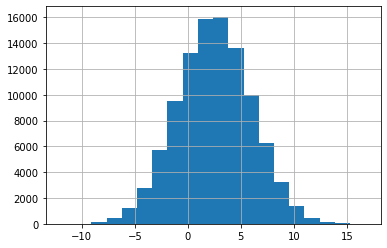

product


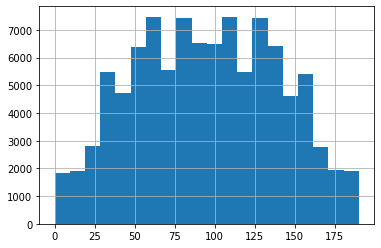

In [16]:
display(df_3.describe())
try:
    display(df_3.describe(include = ['object','bool','datetime']))
    for i in df_3.select_dtypes(include=['object','bool','datetime']):
        print('-----')
        if df_3[i].count() != len(df_3[i].unique()):
            print(df_3[i].value_counts())
        else:
            print('Все значения уникальны')
except:
    print('Все данные представлены в числовом формате')
print('-----')
for i in df_3:     
    if not ((df_3[i].dtype == 'object') & (len(df_3[i].unique()) > 20)):
        print(i)
        if (len(df_3[i].unique()) < 20):
            df_3[i].hist(bins=len(df_3[i].unique()))
            plt.show()  
        else:        
            df_3[i].hist(bins=20)
            plt.show()

In [17]:
df_3[df_3['id'] == 'xCHr8']

,id,f0,f1,f2,product
28039,xCHr8,1.633027,0.368135,-2.378367,6.120525
43233,xCHr8,-0.847066,2.101796,5.597130,184.388641


<font color='DarkBlue'> 
📌 Дубликаты, определяемые по подобным параметрам скважин, отсутствуют <br>
📌 В базе присутствует 4 скважины с одинаковыми идентификаторами, возможно неверно обозначенных по причине наличия ручной ошибки или менее вероятно повторно исследуемых вследствие технологической ошибки, так как остальные их параметры не совпадают, о чем свидетельствует отсутствие дубликатов и выборочное сравнение одного из объектов <br>  
📌 Объем запасов в скважинах нормально варьируется от 0 (абсолютно убыточные) до 191. Остальные параметры имеют выраженное нормальное распределение со снижением значений у периферий гистограммы <br>  
📌 Рекомендуется преобразовать типы данных полей для оптимизации памяти <br>  
📌 Необходимо удалить столбцы, не несущие полезной информации: 'id' <br>  
</font>

In [18]:
df_3[df_3.select_dtypes(include=['int']).columns] = df_3.select_dtypes(include=['int']).apply(pd.to_numeric,downcast='unsigned')
df_3[df_3.select_dtypes(include=['float']).columns] = df_3.select_dtypes(include=['float']).apply(pd.to_numeric,downcast='float')
df_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float32
 2   f1       100000 non-null  float32
 3   f2       100000 non-null  float32
 4   product  100000 non-null  float32
dtypes: float32(4), object(1)
memory usage: 2.3+ MB


In [19]:
df_3 = df_3.drop(['id'], axis=1)

## Обучение и проверка модели

### Создание модели для предсказания объёма запасов первого региона

<font color='DarkBlue'> 
📌 Необходимо создать функцию, используемую в дальнейшем для обучения моделей исследуемых регионов добычи, разбив данные на обучающую и валидационную выборки в соотношении 75:25, и предсказать значения целевого признака для валидационной выборки <br>
📌 Также требуется обозначить скоринг моделей на обучающей и валидационной выборках, средний запас предсказанного сырья <br>
</font>

In [20]:
def fit_model(df, kind):
    df_features = df.drop('product', axis=1)
    df_target = df['product']
    df_features_train, df_features_valid, df_target_train, df_target_valid = train_test_split(df_features, df_target, test_size=0.25, random_state=12345)
    if kind == 'rf':
        model = RandomForestRegressor(random_state=12345)
        grid = RandomizedSearchCV(model, {'n_estimators': range (11, 31, 10), 'max_depth': range (6, 11)}, cv=5)
        grid.fit(df_features_train, df_target_train)
        print('Лучшая модель:', grid.best_estimator_)
        print('Параметры лучшей модели:', grid.best_params_)  
        print('Лучшая метрика score:', grid.best_score_)   
        model = grid.best_estimator_
    else:
        numeric = df.select_dtypes(include=['float32']).drop('product', axis=1).columns
        scaler = StandardScaler()
        scaler.fit(df_features_train[numeric]) 
        df_features_train[numeric] = scaler.transform(df_features_train[numeric])
        df_features_valid[numeric] = scaler.transform(df_features_valid[numeric])
        model = LinearRegression()
        scores = cross_val_score(model, df_features_train, df_target_train, cv=5) 
        final_score = scores.mean()
        print('Усредненное R2 на обучающей выборке', final_score) 
    model.fit(df_features_train, df_target_train)
    df_predicted_valid = model.predict(df_features_valid)
    print('R2 модели на обучающей выборке:', model.score(df_features_train, df_target_train))
    print('R2 модели на валидационной выборке:', model.score(df_features_valid, df_target_valid))
    print('RMSE модели на валидационной выборке:', mean_squared_error(df_target_valid, df_predicted_valid) ** 0.5)
    print('MAE модели на валидационной выборке:', mean_absolute_error(df_target_valid, df_predicted_valid))
    print('Средний запас предсказанного сырья:', df_predicted_valid.mean())
    pd.Series(df_predicted_valid).hist(bins=20)
    plt.show()
    return df_features_train, df_features_valid, df_target_train, df_target_valid, df_predicted_valid

<font color='DarkBlue'> 
📌 Желательно сравнить результаты предсказаний модели с использованием разных алгоритмов, например, случайного леса и линейной регрессии <br>
</font>

 ----- Параметры модели для первого региона ----- 
Лучшая модель: RandomForestRegressor(max_depth=9, n_estimators=21, random_state=12345)
Параметры лучшей модели: {'n_estimators': 21, 'max_depth': 9}
Лучшая метрика score: 0.29048198758592186
R2 модели на обучающей выборке: 0.3276355458475617
R2 модели на валидационной выборке: 0.2970339299921261
RMSE модели на валидационной выборке: 37.130765332964614
MAE модели на валидационной выборке: 30.541731948363026
Средний запас предсказанного сырья: 92.55964959448642


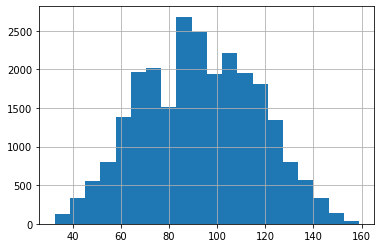

 ----- Параметры модели для второго региона ----- 
Лучшая модель: RandomForestRegressor(max_depth=7, n_estimators=21, random_state=12345)
Параметры лучшей модели: {'n_estimators': 21, 'max_depth': 7}
Лучшая метрика score: 0.9997625287345802
R2 модели на обучающей выборке: 0.9997767943195982
R2 модели на валидационной выборке: 0.9997563305799212
RMSE модели на валидационной выборке: 0.7183876922965949
MAE модели на валидационной выборке: 0.3190762543512469
Средний запас предсказанного сырья: 68.7291540369082


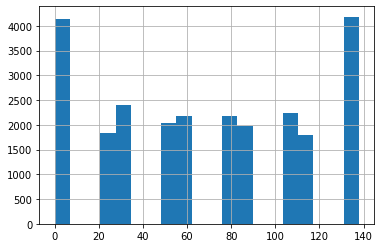

 ----- Параметры модели для третьего региона ----- 
Лучшая модель: RandomForestRegressor(max_depth=10, n_estimators=21, random_state=12345)
Параметры лучшей модели: {'n_estimators': 21, 'max_depth': 10}
Лучшая метрика score: 0.2877975222843939
R2 модели на обучающей выборке: 0.3403266157094328
R2 модели на валидационной выборке: 0.2935170045671779
RMSE модели на валидационной выборке: 37.74134367005765
MAE модели на валидационной выборке: 31.14847677567488
Средний запас предсказанного сырья: 94.96680693712773


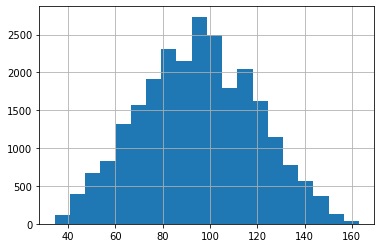

In [21]:
print('\033[1m\033[43m {}'.format('----- Параметры модели для первого региона -----'),'\033[0m')
df_features_train_1, df_features_valid_1, df_target_train_1, df_target_valid_1, df_predicted_valid_1 = fit_model(df_1,'rf')
print('\033[1m\033[43m {}'.format('----- Параметры модели для второго региона -----'),'\033[0m')
df_features_train_2, df_features_valid_2, df_target_train_2, df_target_valid_2, df_predicted_valid_2 = fit_model(df_2,'rf')
print('\033[1m\033[43m {}'.format('----- Параметры модели для третьего региона -----'),'\033[0m')
df_features_train_3, df_features_valid_3, df_target_train_3, df_target_valid_3, df_predicted_valid_3 = fit_model(df_3,'rf')

 ----- Параметры модели для первого региона ----- 
Усредненное R2 на обучающей выборке 0.27408653428909235
R2 модели на обучающей выборке: 0.2742390652670642
R2 модели на валидационной выборке: 0.2799432141403785
RMSE модели на валидационной выборке: 37.57941948134228
MAE модели на валидационной выборке: 30.919603
Средний запас предсказанного сырья: 92.59258


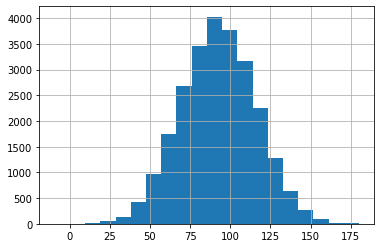

 ----- Параметры модели для второго региона ----- 
Усредненное R2 на обучающей выборке 0.9996246812990066
R2 модели на обучающей выборке: 0.9996247759518483
R2 модели на валидационной выборке: 0.9996233978616408
RMSE модели на валидационной выборке: 0.8930992758632121
MAE модели на валидационной выборке: 0.71876633
Средний запас предсказанного сырья: 68.728546


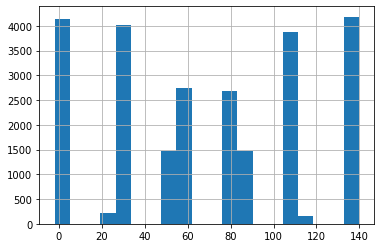

 ----- Параметры модели для третьего региона ----- 
Усредненное R2 на обучающей выборке 0.19648225654588936
R2 модели на обучающей выборке: 0.19661432910542231
R2 модели на валидационной выборке: 0.20524758361558992
RMSE модели на валидационной выборке: 40.0297085110117
MAE модели на валидационной выборке: 32.79265
Средний запас предсказанного сырья: 94.96505


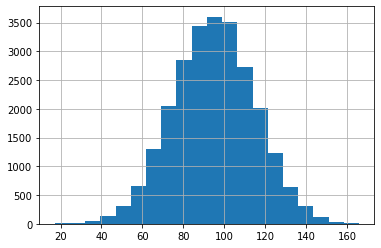

In [22]:
print('\033[1m\033[43m {}'.format('----- Параметры модели для первого региона -----'),'\033[0m')
df_features_train_1, df_features_valid_1, df_target_train_1, df_target_valid_1, df_predicted_valid_1 = fit_model(df_1,'lr')
print('\033[1m\033[43m {}'.format('----- Параметры модели для второго региона -----'),'\033[0m')
df_features_train_2, df_features_valid_2, df_target_train_2, df_target_valid_2, df_predicted_valid_2 = fit_model(df_2,'lr')
print('\033[1m\033[43m {}'.format('----- Параметры модели для третьего региона -----'),'\033[0m')
df_features_train_3, df_features_valid_3, df_target_train_3, df_target_valid_3, df_predicted_valid_3 = fit_model(df_3,'lr')

<font color='DarkBlue'> 
📌 Заметно, что для модели линейной регрессии значения целевого признака наиболее сосредоточены в центральной области гистограмм, соответственно, менее выражен разброс значений, но параметры стандартного отклонения похожии. Точность модели случайного леса немного выше, но в целом показания метрик аналогичны. Наиболее оптимальной моделью является линейная регрессия по причине наименьшего разброса значений ее целевого признака, соответственно, большей определенности модели <br>
📌 Самой точной является модель второго региона, так как значения целевого признака наиболее предсказуемы, наблюдаются явно выраженные равномерно распределенные скопления и провалы. Средний запас предсказанного ею сырья наименьший, но присутствует наибольшее количество прибыльных и убыточных скважин. Модели других регионов похожи, наблюдается нормальное распределение значений целевого признака, но наиболее точной является первая <br>
</font>

## Подготовка к расчёту прибыли

<font color='DarkBlue'> 
📌 Бюджет на разработку скважин в регионе — 10 млрд. рублей, соответственно, и совокупные расходы на 200 лучших скважин для разработки <br>
📌 Необходимо также определить доход с каждой скважины для безубыточной разработки и объем продукции <br>
</font>

In [23]:
costs = 10000000000
print('Расходы:', costs)
income_rub = costs/200
print('Точка безубыточности одной скважины, руб.:', income_rub)
price = 450000
print('Доход с единицы продукта (1000 баррелей), руб.:', price)
income_bar = income_rub/price
print('Точка безубыточности одной скважины, ед.:', income_bar)

Расходы: 10000000000
Точка безубыточности одной скважины, руб.: 50000000.0
Доход с единицы продукта (1000 баррелей), руб.: 450000
Точка безубыточности одной скважины, ед.: 111.11111111111111


<font color='DarkBlue'> 
📌 Можно определить средний запас сырья в каждом регионе <br>
</font>

In [24]:
print('Предсказанный запас сырья средней скважины в первом регионе, ед.:', df_predicted_valid_1.mean())
print('Фактический запас сырья средней скважины в первом регионе, ед.:', df_target_valid_1.mean())
print('Предсказанный запас сырья средней скважины во втором регионе, ед.:', df_predicted_valid_2.mean())
print('Фактический запас сырья средней скважины в первом регионе, ед.:', df_target_valid_2.mean())
print('Предсказанный запас сырья средней скважины в третьем регионе, ед.:', df_predicted_valid_3.mean())
print('Фактический запас сырья средней скважины в первом регионе, ед.:', df_target_valid_3.mean())

Предсказанный запас сырья средней скважины в первом регионе, ед.: 92.59258
Фактический запас сырья средней скважины в первом регионе, ед.: 92.0786
Предсказанный запас сырья средней скважины во втором регионе, ед.: 68.728546
Фактический запас сырья средней скважины в первом регионе, ед.: 68.72313
Предсказанный запас сырья средней скважины в третьем регионе, ед.: 94.96505
Фактический запас сырья средней скважины в первом регионе, ед.: 94.88424


<font color='DarkBlue'> 
📌 Фактический запас сырья для средней скважины каждого региона коррелируется с предсказанным значением <br>
📌 Запасы сырья для усредненных скважин в регионах меньше объема, требуемого для безубыточной разработки новой скважины. Поэтому необходимо выбрать 200 лучших по предсказаниям обученных моделей в каждом регионе для освоения бюджета в соответствии с заданием <br>    
</font>

## Расчёт прибыли и рисков 

<font color='DarkBlue'> 
📌 Требуется обозначить функцию для расчёта прибыли (разницу между доходами и расходами) по выбранным 200 скважинам в соответствии с наилучшими (максимальными) значениями добываемого сырья предсказаний модели <br> 
</font>

In [25]:
def calculation(df_target_valid, df_predicted_valid):
    df_predicted_valid_series = pd.Series(df_predicted_valid)
    df_predicted_valid_series.index = df_target_valid.index
    sum_bar = df_target_valid.loc[df_predicted_valid_series.sort_values(ascending=False).index][:200].sum()
    sum_rub = df_target_valid.loc[df_predicted_valid_series.sort_values(ascending=False).index][:200].sum() * 450000 - costs
    return sum_bar, sum_rub

<font color='DarkBlue'> 
📌 Для каждого региона неоТебходимо определить объем сырья и прибыли с рассматриваемых скважин с помощью вышеуказанной функции <br> 
</font>

In [26]:
sum_bar_1, sum_rub_1 = calculation(df_target_valid_1, df_predicted_valid_1)
sum_bar_2, sum_rub_2 = calculation(df_target_valid_2, df_predicted_valid_2)
sum_bar_3, sum_rub_3 = calculation(df_target_valid_3, df_predicted_valid_3)
print('Объем полученного сырья со скважин первого региона', sum_bar_1)
print('Объем полученного сырья со скважин второго региона', sum_bar_2)
print('Объем полученного сырья со скважин третьего региона', sum_bar_3)
print('Объем прибыли со скважин первого региона, руб.', sum_rub_1)
print('Объем прибыли со скважин второго региона, руб.', sum_rub_2)
print('Объем прибыли со скважин третьего региона, руб.', sum_rub_3)

Объем полученного сырья со скважин первого региона 29601.836
Объем полученного сырья со скважин второго региона 27589.086
Объем полученного сырья со скважин третьего региона 28245.22
Объем прибыли со скважин первого региона, руб. 3320826171.875
Объем прибыли со скважин второго региона, руб. 2415088671.875
Объем прибыли со скважин третьего региона, руб. 2710349316.40625


<font color='DarkBlue'> 
📌 Наиболее прибыльным является первый регион при наличии информации о лучших объектах для разработки, затем третий и, соответственно, второй. Объем полученного сырья прямо пропорционален данным значениям. Все регионы имеют положительную прибыль <br> 
📌 Можно дополнительно указать получаемый объем сырья с наилучших скважин в регионе в соответстии с фактическими и предсказанными значениями по отдельности для определения качества работы модели. <br> 
</font>

In [27]:
print('Фактический объем полученного сырья со скважин первого региона', df_target_valid_1.sort_values(ascending=False)[:200].sum())
print('Предсказанный объем полученного сырья со скважин первого региона', pd.Series(df_predicted_valid_1).sort_values(ascending=False)[:200].sum())
print('Фактический объем полученного сырья со скважин второго региона', df_target_valid_2.sort_values(ascending=False)[:200].sum())
print('Предсказанный объем полученного сырья со скважин второго региона', pd.Series(df_predicted_valid_2).sort_values(ascending=False)[:200].sum())
print('Фактический объем полученного сырья со скважин третьего региона', df_target_valid_3.sort_values(ascending=False)[:200].sum())
print('Предсказанный объем полученного сырья со скважин третьего региона', pd.Series(df_predicted_valid_3).sort_values(ascending=False)[:200].sum())

Фактический объем полученного сырья со скважин первого региона 36690.992
Предсказанный объем полученного сырья со скважин первого региона 31102.336
Фактический объем полученного сырья со скважин второго региона 27589.086
Предсказанный объем полученного сырья со скважин второго региона 27746.031
Фактический объем полученного сырья со скважин третьего региона 37650.36
Предсказанный объем полученного сырья со скважин третьего региона 29603.9


<font color='DarkBlue'> 
📌 Модель для второго региона наиболее точно предсказывает объем добычи с самых рентабельных скважин, как было указано ранее. Показания для третьей модели меньше остальных соответствуют фактическим значениям  <br> 
📌 Также можно определить необходимый для безубыточной разработки доход с 200 наиболее прибыльных скважин для каждого региона <br> 
</font>

In [28]:
income_region = costs/price
print('Точка безубыточности одного региона, ед.:', income_region)

Точка безубыточности одного региона, ед.: 22222.222222222223


<font color='DarkBlue'> 
📌 В соответствии с выводом о прибыльности предсказанных значений всех указанных выше расчетов точка безубыточности количества добываемого сырья всегда будет меньше. Следует проверить, не является ли подобное предположение случайным <br> 
📌 Для этого необходимо определить прибыль и риски убыточности для каждого региона в соответствии с предсказаниями обученных моделей, предварительно указав общую функцию определения ключевых метрик с применением техники bootstrap, рассматривая предсказания 200 из 500 случайных скважин: среднюю прибыль, 95%-й доверительный интервал и точку, определяющую вероятность разработки при получении нулевой доходности. Также полезно отобразить распределение прибыли <br> 
</font>

In [29]:
state = np.random.RandomState(12345)
def analysis(df_target_valid, df_predicted_valid):
    values = []
    for i in range(1000):
        target_subsample = df_target_valid.sample(n=500, replace=True, random_state=state)
        df_predicted_valid_series = pd.Series(df_predicted_valid)
        df_predicted_valid_series.index = df_target_valid.index    
        predict_subsample = df_predicted_valid_series.loc[target_subsample.index]
        values.append(calculation(target_subsample, predict_subsample))
    values = pd.DataFrame(values)[1]
    mean = values.mean()
    print("Средняя выручка:", mean)
    lower = values.quantile(0.025)
    print("2.5%-квантиль:", lower)
    higher = values.quantile(0.975)
    print("97.5%-квантиль:", higher)
    confidence_interval = st.t.interval(0.95, len(values)-1, values.mean(), values.sem())
    print('95%-ый доверительный интервал:', confidence_interval)
    risk = st.norm(values.mean(), values.std()).cdf(0)
    print('Риск убытков, %:', risk * 100) 
    plt.plot(range(int(values.mean() - 3 * values.std()), int(values.mean() + 3 * values.std()), 1000),st.norm.pdf(range(int(values.mean() - 3 * values.std()), int(values.mean() + 3 * values.std()), 1000), values.mean(), values.std()))
    plt.show()
    values.hist(bins=20)
    plt.show()

 ----- Параметры предсказанной прибыли для первого региона ----- 
Средняя выручка: 425938506.34765625
2.5%-квантиль: -102090039.0625
97.5%-квантиль: 947976479.4921875
95%-ый доверительный интервал: (408732186.78535104, 443144825.90996146)
Риск убытков, %: 6.225085258015766


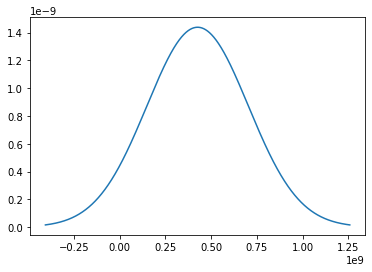

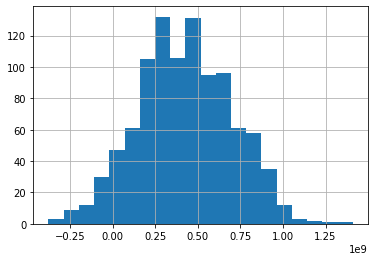

 ----- Параметры предсказанной прибыли для второго региона ----- 
Средняя выручка: 518260765.625
2.5%-квантиль: 128124489.74609375
97.5%-квантиль: 953614091.796875
95%-ый доверительный интервал: (505251152.9240029, 531270378.3259971)
Риск убытков, %: 0.6716897899605077


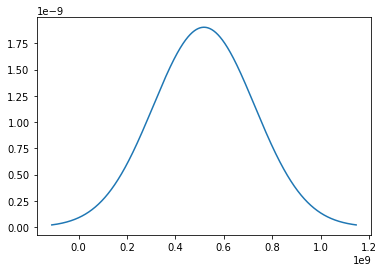

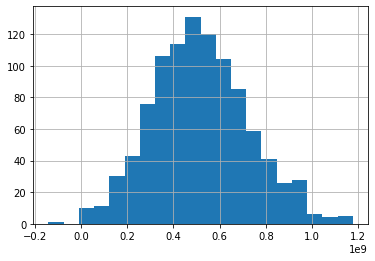

 ----- Параметры предсказанной прибыли для третьего региона ----- 
Средняя выручка: 420193979.4921875
2.5%-квантиль: -115852612.3046875
97.5%-квантиль: 989630483.3984375
95%-ый доверительный интервал: (402528678.06540674, 437859280.91896826)
Риск убытков, %: 6.996419312669438


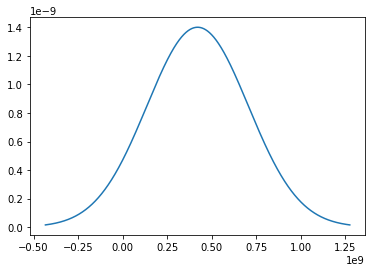

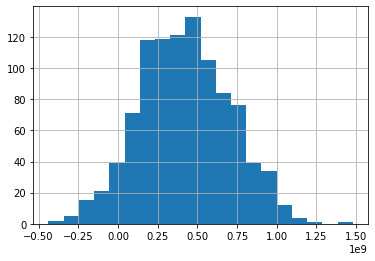

In [30]:
print('\033[1m\033[43m {}'.format('----- Параметры предсказанной прибыли для первого региона -----'),'\033[0m')
analysis(df_target_valid_1, df_predicted_valid_1)
print('\033[1m\033[43m {}'.format('----- Параметры предсказанной прибыли для второго региона -----'),'\033[0m')
analysis(df_target_valid_2, df_predicted_valid_2)
print('\033[1m\033[43m {}'.format('----- Параметры предсказанной прибыли для третьего региона -----'),'\033[0m')
analysis(df_target_valid_3, df_predicted_valid_3)

<font color='DarkBlue'> 
📌 Исходя из указанной информации определяется, что для второго региона риск убыточности минимален, менее 1%, для остальных 6-7%. Следовательно, только во втором регионе вероятность убытков менее 2.5%, со скважин которого также получена наибольшая средняя прибыль. Объем продукта этого региона наиболее предсказуем и имеется большее количество наиболее прибыльных скважин в соответсвии с гистограммой, обозначенной в начале исследования. Средние значения с 95 % вероятностью попадают в текущий доверительный интервал. Данный регион будет лучшим для разработки скважин <br> 
    
📌 На основании произведенных исследований можно сформировать следующие выводы: <br>   
- предоставленные данные хорошего качества, для более удобного анализа необходимо преобразование типов данных в форматы, занимающие меньший объем памяти, и удаление неинформативного поля 'id' <br>
- определено, что наилучшим алгоритмом обучения модели для прогноза ухода клиентов по исходным данным будет являться наиболее предсказуемая 'Линейная регрессия' <br>    
- Лучшим регионом для разработки скважин по предсказаниям объема добычи в соответствии с их параметрами является второй, обученная модель которого отличается наиболее точными предсказаниями, соответсвенно, минимальными рисками убыточности, и достаточным количеством продуктивных объектов
</font>